In [4]:
import os
import sys
import scipy
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import pinv
from tqdm import tqdm

sys.path.append('../')
from preprocessing import *
os.chdir('../../SpectraFit/')
import data_processing.preprocessing as preprocessing
from config import dataset_path

In [16]:
left_cut = 740
right_cut = 900
reference_index = 100 # starting spectrum for inference
time_cut = 500 # at what timepoint to stop inference

# load data
img_mat = scipy.io.loadmat(dataset_path + 'LWP498/LWP498_Ws_24Apr2017_15.mat')
dark_ref = scipy.io.loadmat(dataset_path + 'LWP498/LWP498 _DarkCount_24Apr2017.mat')['DarkCount'].astype(float) # shape (k,n)
white_ref = img_mat['refIntensity'].astype(float) # shape (k,m)
spectr = img_mat['spectralDataAll'].astype(float)[:,reference_index:time_cut].T # shape (time_cut-reference_index, k)
band_centers = img_mat['wavelengths'].astype(float).squeeze() # shape (k,)
concentrations_paper = img_mat['AllConcentration']

# average dark and white reference and add dimension for shape (1,k)
white_ref = np.mean(white_ref, axis=-1)[np.newaxis, :]
dark_ref = np.mean(dark_ref, axis=-1)[np.newaxis, :]

# extract wavelengths between 760 and 900
band_limits = [left_cut, right_cut]
spectr, _ = band_removal(spectr, band_limits, band_centers)
white_ref, _ = band_removal(white_ref, band_limits, band_centers)
dark_ref, band_centers_new = band_removal(dark_ref, band_limits, band_centers)

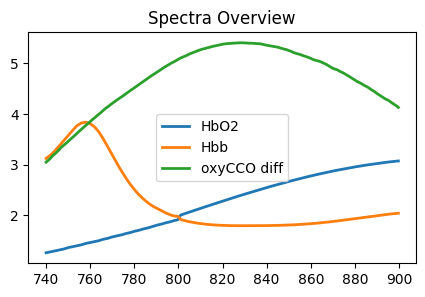

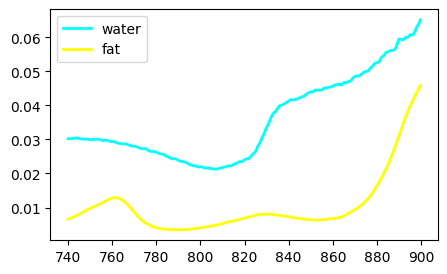

In [6]:
# load cytochrome spectra
molecules, x = preprocessing.read_molecules(left_cut, right_cut, band_centers_new)
y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat = molecules

# plot cytochrome spectra
plt.figure(figsize=(5,3))
coef = ["HbO2", "Hbb", "oxyCCO diff"]
coef_list = [y_hbo2_f, y_hb_f, y_coxa-y_creda]
for i in range(len(coef)):
    plt.plot(band_centers_new, M[:,i], label=coef[i], linewidth=2)
plt.title("Spectra Overview")
plt.legend()
plt.figure(figsize=(5,3))
plt.plot(band_centers_new, y_water, color="cyan", label="water", linewidth=2)
plt.plot(band_centers_new, y_fat, color="yellow", label="fat", linewidth=2)
plt.legend()

Assuming a LMM the Apsorption is given as $$A(t)=Mc(t)$$ where M is a matrix containing the absorption spectra, and c(t) is a vector of the endmember concentrations. Assuming only a subset of the concentrations changes over time, we can rewrite the equation as $$A(t) = \begin{bmatrix} M_1\\ M_2 \end{bmatrix} [c_1(t), c_2] = M_1c_1(t) + C$$ where $C=M_2c_2$ is a time-invariant vector.

To solve the problem we can alternate between updating $c_1$ and $C$:
$$c_1(t_i) \leftarrow M^{-1}\bigl(A(t_i)-C\bigr) \quad \forall i \in [0,N]$$
$$C \leftarrow \frac{1}{N}\sum_{i=0}^{N} A(t_i)-M_1c_1(t_i)$$

(400, 244)


100%|██████████| 10/10 [00:00<00:00, 59.92it/s]


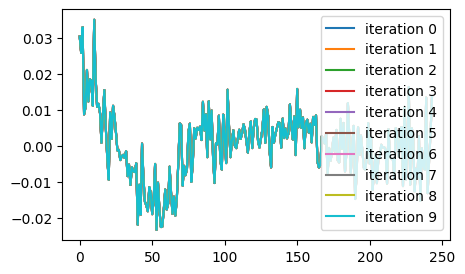

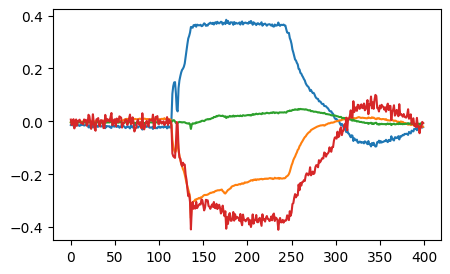

In [23]:
spectr_calib = calibrate_img(spectr, white_ref, dark_ref)

A = np.log(spectr_calib)
print(A.shape)
M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                            np.asarray(y_hb_f),
                            np.asarray(y_coxa - y_creda),
                            y_water*10)))
M_pinv = pinv(M)


fig, ax = plt.subplots(1, 1, figsize=(5,3))

# initialize variables
N, k = A.shape
m = M.shape[1]
c = np.zeros((N,m))
C = np.zeros(k)

for i in tqdm(range(10)):
    C_new = np.zeros(k)
    for j in range(N):
        c[j,:] = M_pinv @ (A[j,:] - C)
        C_new += A[j,:] - M @ c[j,:]
    C = C_new / N
    ax.plot(C, label="iteration {}".format(i))
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(c)

In [30]:
def f(X,*arg):
    A = arg[0]
    M = arg[1] # cytochrome spectra
    m = M.shape[1]
    c_i = X[:N*m].reshape((N,m))
    C = X[N*m:]
    residual = 0
    for j in range(N):
        residual += np.linalg.norm(A[j,:] - M @ c_i[j,:] - C)
    return residual


spectr_calib = calibrate_img(spectr, white_ref, dark_ref)

A = np.log(spectr_calib)
print(A.shape)
M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                            np.asarray(y_hb_f),
                            np.asarray(y_coxa - y_creda))))


# initialize variables
N, k = A.shape
m = M.shape[1]

X = np.zeros(N*m+k)
left_bound = np.zeros(N*m+k)
right_bound = np.append(np.ones(N*m), np.ones(k)*np.inf)
result = scipy.optimize.least_squares(f, X, args=(A, M), bounds=(left_bound, right_bound))

c_i = result.x[:N*m].reshape((N,m))
C = result.x[N*m:]

plt.figure()
ax.plot(C)
plt.figure()
ax.plot(c_i)


(400, 244)


KeyboardInterrupt: 